In [1]:
%load_ext line_profiler
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

import warnings
warnings.filterwarnings('error')

In [2]:
records=pd.read_csv('data/ydata-fp-td-clicks-v2_0.20111005', 
                    sep=' ',
                    names=['timestamp','id','clicked'],
                    usecols=[0,1,2],)

In [3]:
records.head()

,timestamp,id,clicked
0,1317772490,id-570650,0
1,1317772491,id-570332,0
2,1317772492,id-568437,0
3,1317772492,id-571362,0
4,1317772492,id-568890,0


In [4]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)

24 1317830699 1317783600 13.083055555555555


51

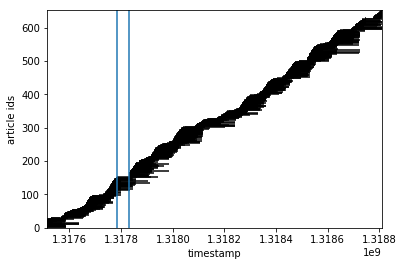

In [5]:
#plt.figure(figsize=(10,20))
y=0
for start,stop in lifespans.values():
    plt.hlines(y, xmin=start, xmax=stop)
    #plt.scatter(np.arange(start,stop,1000),[y for j in range(start,stop,1000)], marker='.')
    y+=1
plt.xlabel('timestamp')
plt.ylabel('article ids')
plt.xlim(1317513291, 1318809293)
plt.ylim(0,652)

l=[] # min heap with items like: (stop, start, arm)
global_max=0
for i in lifespans.items():
    arm=i[0]
    start,stop=i[1]
    while l and l[0][0]<start:
        heapq.heappop(l)
        if len(l)>=24:
            min_stop=l[0][0]
            max_start=max(l, key=lambda i:i[1])[1]
            if min_stop-max_start>=3600*12:
                plt.axvline(min_stop)
                plt.axvline(max_start)
                pool=[i[2] for i in l]
                print(len(l), min_stop, max_start, (min_stop-max_start)/3600)
    heapq.heappush(l,(stop,start,arm)) # min stop (earliest expiring)
    
    global_max=max(global_max, len(l))
global_max

In [6]:
start=records[records.timestamp==1317783600].index[0]
stop=records[records.timestamp==1317830699].index[-1]
slice=records.iloc[start:stop+1]
slice.head()

,timestamp,id,clicked
350160,1317783600,id-572194,0
350161,1317783600,id-572582,0
350162,1317783600,id-569364,0
350163,1317783600,id-569270,0
350164,1317783600,id-573053,0


In [11]:
slice4 = pd.concat([slice,slice,slice,slice])

In [12]:
slice4.index = range(len(slice4))

In [8]:
class Epsilon_z_greedy:
    def __init__(self, records=slice, pool=pool, G=slice.timestamp.value_counts()):
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.rewards = 0
        self.pool = {}
        self.G = G
        for k in pool:
            self.pool[k] = Arm()
        self.best = None
        self.prev_time = None
        
    def update(self, record):
        self.rewards += record.clicked
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T
        if not self.best: # first record
            self.best = record.id
        else:
            if record.timestamp != self.prev_time:
                #if record.id==self.best: # reselect the best arm
                self.best = max(self.pool, key=lambda arm:self.pool[arm].X)
                #else: # only need to compare current arm and original best arm
                 #   self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        self.prev_time = record.timestamp
                
    def initialize(self, m=24):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            if record.id not in self.pool:
                continue
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, m=24, z=31, threshold=.3, mode='z'):
        ez=[]
        k=250 # k>4/(best.X-2ndBest.X)
        self.t_ = 1
        minG = float('inf')
        for t in range(m, n):
            while True: # keep feeding event stream until event matches desired action
                
                record = next(self.records) # raise StopIteration
                if record.id not in self.pool:
                    continue
                                
                if mode=='soft':
                    minG = min(self.G[record.timestamp], minG)
                    phi = np.log(1+1/self.G[record.timestamp]) / np.log(1+ 1/minG)
                    epsilon = min(phi, k*m/t)
                else:
                    epsilon = min(1, k*m/self.t_)
                if self.G[record.timestamp]<z and random.random()<epsilon:
                    pick = random.choice(list(self.pool))
                else:
                    pick = self.best
                #print(pick, record.id, record.timestamp, record.clicked)
                if pick == record.id:
                    ez.append(epsilon)
                    self.update(record)
                    if self.G[record.timestamp]<z:
                        self.t_ += 1
                    break
        plt.plot(ez)

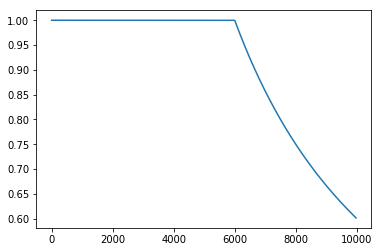

In [163]:
ezg = Epsilon_z_greedy(slice4)
ezg.initialize()
ezg.play(10000,z=float('inf'))

In [150]:
ezg.rewards

763

In [341]:
l7=[]
for i in range(100):
    vp = Variable_Pool(slice4)
    vp.initialize()
    vp.play(10000)
    l7.append(vp.rewards)
    print(i, end='\r', flush=True)

In [151]:
l1=[]
l2=[]
l3=[]
for i in range(100):
    ezg = Epsilon_z_greedy(slice4)
    ezg.initialize()
    ezg.play(10000)
    l1.append(ezg.rewards)

    ezg = Epsilon_z_greedy(slice4)
    ezg.initialize()
    ezg.play(10000, z=float('inf')) # vallina epsilon
    l2.append(ezg.rewards)
    
    ezg = Epsilon_z_greedy(slice4)
    ezg.initialize()
    ezg.play(10000, mode='soft', z=float('inf'))
    l3.append(ezg.rewards)
    
    print(i, end='\r', flush=True)

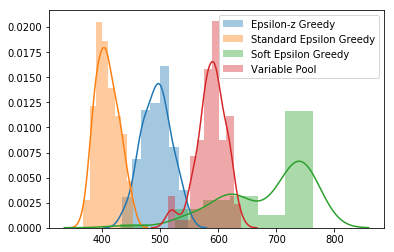

In [344]:
sns.distplot(l1, label='Epsilon-z Greedy')
sns.distplot(l2, label='Standard Epsilon Greedy')
sns.distplot(l3, label='Soft Epsilon Greedy')
sns.distplot(l7, label='Variable Pool')
plt.legend()
#plt.title('reward distributions')

In [348]:
ttest_ind(l1,l2)

Ttest_indResult(statistic=26.687693761568426, pvalue=1.6575688905150123e-67)

In [345]:
ttest_ind(l3,l2)

Ttest_indResult(statistic=34.99024059918462, pvalue=1.019698890484152e-86)

In [349]:
ttest_ind(l7,l2)

Ttest_indResult(statistic=56.1860113018189, pvalue=1.2419948856834873e-123)

In [9]:
class Arm:
    def __init__(self):
        self.T = 0
        self.rewards = 0
        self.X = -1
        self.ucb = float('inf')
        self.soft_ucb = float('inf')
    def __repr__(self):
        return '{:.4f} {}/{} {} {}'.format(self.X, self.rewards, self.T, self.ucb, self.soft_ucb)

In [10]:
class UCB_z:
    def __init__(self, records, pool=pool):
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.rewards = 0
        self.pool = {}
        for k in pool:
            self.pool[k] = Arm()
        self.best = None
        self.prev_time = None        
        self.G = records.timestamp.value_counts() # estimation of G(t) counted from records
        
    def update(self, record):
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T
        arm.ucb = arm.X + np.sqrt(2*np.log(self.t)/arm.T)
        epsilon = (1 + self.t/self.G[record.timestamp])
        arm.soft_ucb = arm.X + np.sqrt(2*np.log(epsilon)/arm.T)
        self.rewards += record.clicked
        if not self.best:
            self.best = record.id
        else:
            if record.timestamp != self.prev_time:
                self.best = max(self.pool, key=lambda arm:self.pool[arm].X)
        self.prev_time = record.timestamp
    
    def play(self, n, z=31, mode='z'):
        if mode=='soft':
            z=float('inf')
        self.t=1
        while self.t<n:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration:
                print('running out of records at turn', self.t)
                break
            if record.id not in self.pool:
                continue
            if self.G[record.timestamp]<z:
                if mode=='soft':
                    pick = max(self.pool, key=lambda key:self.pool[key].soft_ucb )
                else:
                    pick = max(self.pool, key=lambda key:self.pool[key].ucb)
            else:
                #pick = max(self.pool, key=lambda key:self.pool[key].X)
                pick = self.best
                    
            if pick == record.id: # historical action matches proposed action
                self.update(record)
                self.t+=1
                

In [15]:
ucbz = UCB_z(records=slice4[:100000])
#ucbz.initialize()
ucbz.play(2000)
ucbz.rewards

77

In [277]:
softz = UCB_z(records=slice4)
#ucbz.initialize()
softz.play(2000, mode='soft')
softz.rewards

81

In [16]:
(len(slice4)-100000)/100

4152.92

In [17]:
plt_ucbz=[]
plt_ucb=[]
plt_ucb_soft=[]
data=slice4
window_size = 100000
step = 4000
turns = 2000
for i in range(100):
    #print('ucbz')
    ucbz = UCB_z(records=data[i*step:window_size+i*step])
    ucbz.play(turns)
    plt_ucbz.append(ucbz.rewards)
    #print('ucb')
    ucbz = UCB_z(records=data[i*step:window_size+i*step])
    ucbz.play(turns, z=float('inf')) # 
    plt_ucb.append(ucbz.rewards)
    #print('ucbz soft')
    ucbz = UCB_z(records=data[i*step:window_size+i*step])
    ucbz.play(turns, z=float('inf'), mode='soft')
    plt_ucb_soft.append(ucbz.rewards)
    
    print(i, end='\r', flush=True)

running out of records at turn 1981


In [ ]:
import pickle
with open('save/plt_ucbz','wb') as f:
    pickle.dump()

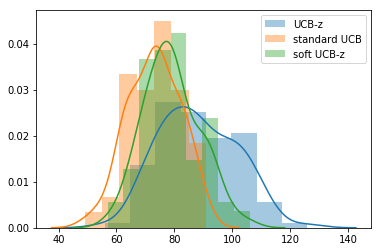

In [18]:
sns.distplot(plt_ucbz, label='UCB-z')
sns.distplot(plt_ucb, label='standard UCB')
sns.distplot(plt_ucb_soft, label='soft UCB-z')
plt.legend()

In [21]:
sum(plt_ucb)/200000, sum(plt_ucb_soft)/200000, sum(plt_ucbz)/200000

(0.03651, 0.03955, 0.044085)

Text(0.5, 1.0, 'reward distributions')

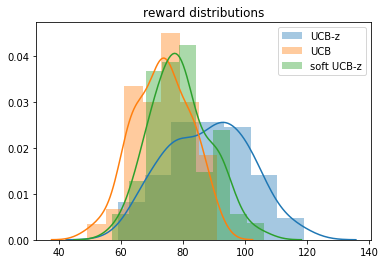

In [289]:
sns.distplot(l4, label='UCB-z')
sns.distplot(l5, label='standard UCB')
sns.distplot(l6, label='soft UCB-z')
plt.legend()

In [71]:
from scipy.stats import ttest_ind

In [290]:
ttest_ind(l4,l5)

Ttest_indResult(statistic=9.332750873492982, pvalue=2.142085453918517e-17)

In [291]:
ttest_ind(l5,l6)

Ttest_indResult(statistic=-4.612053568557072, pvalue=7.146170462902074e-06)

In [312]:
class Variable_Pool:
    def __init__(self, records, pool=pool):
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.G = records.timestamp.value_counts()
        self.rewards = 0
        self.pool = {}
        self.rank = []
        for k in pool:
            self.rank.append(k)
            self.pool[k] = Arm()        
        self.prev_time = None
        
    def update(self, record):
        self.rewards += record.clicked
        arm = self.pool[record.id]
        arm.rewards += record.clicked
        arm.T += 1
        arm.X = arm.rewards / arm.T

        if record.timestamp != self.prev_time:
            self.rank.sort(key=lambda article:self.pool[article].X, reverse=True)    
        self.prev_time = record.timestamp
                
    def initialize(self, m=24):
        i=0
        while i<m:
            record = next(self.records) # raise StopIteration
            if record.id not in self.pool:
                continue
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, m=24, z=31, c=10):
        self.mts={}
        
        k=250 # k>4/(best.X-2ndBest.X)
        self.t_ = 1
        for t in range(m, n):
            while True: # keep feeding event stream until event matches desired action
                
                record = next(self.records) # raise StopIteration
                if record.id not in self.pool:
                    continue
                                
                mt = int(min(m, max(1, c*m / t*self.G[record.timestamp])))
                self.mts[record.timestamp] = mt
                pick = random.choice(self.rank[:mt])
                #print(pick, record.id, record.timestamp, record.clicked)
                if pick == record.id:
                    self.update(record)
                    if self.G[record.timestamp]<z:
                        self.t_ += 1
                    break


In [336]:
vp = Variable_Pool(slice)
vp.initialize()
vp.play(2000)

In [337]:
vp.rewards

101